# Ultimate Take Home Challenge
In this exercise, 'Uber-like' taxi data is examined to determine factors that predict customer retention.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
logins = pd.read_json('logins.json')

In [2]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
logins.nunique()

login_time    92265
dtype: int64

There are a handful of dulicated login times. This should be reasonable as more than one person can log on at a time. 

Count the number of logins for each account. Here I set a dummy variable column so that .count() has something to count:

In [5]:
logins['num_logins'] = 1

In [6]:
login_time = logins.set_index('login_time')
login_summary = login_time.resample('15T').count()

In [7]:
login_summary.head()

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Number of logins in 15-minute intervals')

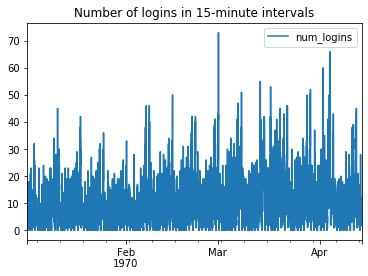

In [8]:
login_summary.plot()
plt.xlabel('')
plt.title('Number of logins in 15-minute intervals')

Looks like clean time series data. The number of logins looks like if falls to zero at times. That seems like reasonable behavior for low demand times. Let's look at one month's worth. February. This month has the Valentine's Day holiday. 

Text(0.5, 1.0, 'February logins')

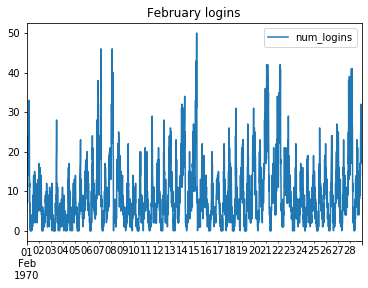

In [9]:
login_summary['Feb 1970'].plot()
plt.xlabel('')
plt.title('February logins')

Looks good. There's that spike on Valentine's Day! 

For periodic behavior, we've got to look at an autocorrelelogram. Peaks in this plot represent obvious periodic features.

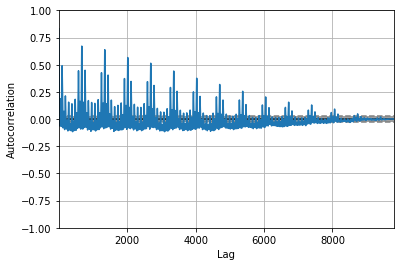

In [10]:
pd.plotting.autocorrelation_plot(login_summary)

Looks good. Lots of peaks to consider. I'll translate the lags unit into real time values next:

In [11]:
logins = pd.Series(login_summary['num_logins'])
ac = []
for lag in range(32*24*4):
    ac.append(logins.autocorr(lag))

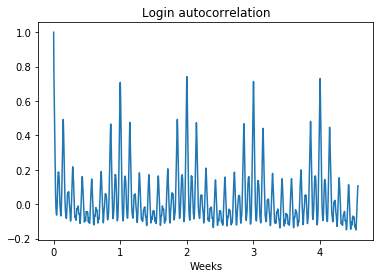

In [12]:
import matplotlib.pyplot as plt
plt.plot([i/(24*4*7) for i in range(len(ac))],ac)
plt.xlabel('Weeks')
plt.title('Login autocorrelation')
plt.show()

Here's a litte more than one month's autocorrelation. Looks like the strongest cycle is weekly with daily peaks in between?

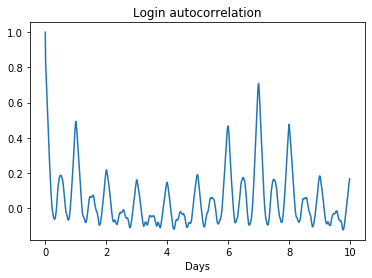

In [13]:
login_autocorrelation_week = ac[:(24*4*10)]
plt.plot([i/(24*4) for i in range(len(login_autocorrelation_week))],login_autocorrelation_week)
plt.xlabel('Days')
plt.title('Login autocorrelation')
plt.show()

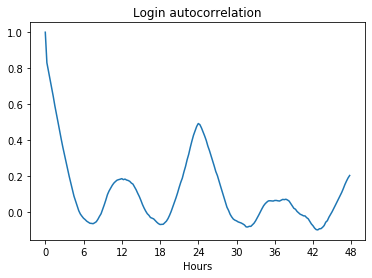

In [14]:
login_autocorrelation_week = ac[:(24*4*2)]
plt.plot([i/(4) for i in range(len(login_autocorrelation_week))],login_autocorrelation_week)
plt.xlabel('Hours')
plt.xticks([0,6,12,18,24,30,36,42,48])
plt.title('Login autocorrelation')
plt.show()

There's definitely daily autocorrelation, and every 12 hours too. 

Now let's look at that customer data for the experiment. Start by printing the info, then look at a sample of rows with at least one missing value.

In [15]:
data = pd.read_json('ultimate_data_challenge.json')
print(data.info())
data[data.isnull().any(axis=1)].sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
27244,Astapor,2,2014-01-29,NaN,1.00,2014-06-05,iPhone,0.0,False,50.0,2.38,5.0
15797,King's Landing,0,2014-01-29,NaN,1.00,2014-07-01,iPhone,0.0,True,100.0,9.92,5.0
5508,Winterfell,1,2014-01-10,NaN,1.00,2014-01-11,iPhone,0.0,True,100.0,10.66,5.0
20801,Winterfell,1,2014-01-20,NaN,1.25,2014-02-24,iPhone,50.0,False,50.0,2.39,5.0
38958,Winterfell,0,2014-01-26,NaN,1.00,2014-06-01,Android,0.0,False,0.0,3.28,5.0
4762,Winterfell,0,2014-01-02,NaN,1.00,2014-02-19,iPhone,0.0,False,100.0,3.63,5.0
38602,Winterfell,1,2014-01-22,NaN,1.00,2014-02-20,Android,0.0,False,100.0,14.98,4.0
797,Astapor,1,2014-01-15,NaN,1.00,2014-01-19,iPhone,0.0,False,0.0,8.61,5.0
22573,Winterfell,1,2014-01-12,NaN,1.50,2014-02-15,iPhone,50.0,False,50.0,3.62,5.0
22176,King's Landing,0,2014-01-20,NaN,1.00,2014-06-07,iPhone,0.0,False,0.0,0.11,5.0


Most of the NaN values are from missing ratings of the driver. Is it riders who rate the drivers here? Maybe they're too busy to fill out the survey at the end of the ride?

To start, let's just drop null values for the predictive modeling analysis. If we have more time, we can come back to impute values, run a model with this feature dropped, or to use other techniques to handle these rows.

In [16]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [17]:
last_date = pd.to_datetime(data.last_trip_date).max()
print(last_date)
active = pd.to_datetime(data['last_trip_date']) > pd.to_datetime('2014-06-01')
print(active.value_counts())
true_six_months = (pd.to_datetime(data['last_trip_date']) - pd.to_datetime(data['signup_date'])) > pd.Timedelta(180,'days')
print(true_six_months.value_counts())

2014-07-01 00:00:00
False    24837
True     16608
Name: last_trip_date, dtype: int64
False    41433
True        12
dtype: int64


There are only 12 "true" six-month riders in this dataset. If we relax the criteria to have riders still active by June, we get a lot more riders. Let's use the relaxed definition of six-months-active.

In [18]:
data.drop(['signup_date','last_trip_date'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   avg_rating_of_driver    41445 non-null  float64
 3   avg_surge               41445 non-null  float64
 4   phone                   41445 non-null  object 
 5   surge_pct               41445 non-null  float64
 6   ultimate_black_user     41445 non-null  bool   
 7   weekday_pct             41445 non-null  float64
 8   avg_dist                41445 non-null  float64
 9   avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
features = pd.get_dummies(data,drop_first=True)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(features,active,test_size=0.33)

In [21]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

       False       0.80      0.81      0.80      8196
        True       0.71      0.69      0.70      5481

    accuracy                           0.76     13677
   macro avg       0.75      0.75      0.75     13677
weighted avg       0.76      0.76      0.76     13677



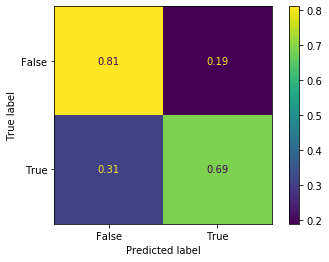

In [22]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,X_test,y_test,normalize='true')

from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

Let's look at the model performance. At first glance, it doesn't look too bad. We have better accuracy in predicting not-active users than active users. It has higher F1, precision and recall. Probably this is becuase we have more support of this class. 

In [23]:
feature_importances = {}
for i,column in enumerate(features.columns):
    feature_importances[column] = model.feature_importances_[i]

from collections import OrderedDict
sorted_features = OrderedDict(sorted(feature_importances.items(), key=lambda kv: kv[1],reverse=True))
for key,value in sorted_features.items():
    print(key,' : ', value)

avg_dist  :  0.2692721970104854
weekday_pct  :  0.13486809840485736
avg_rating_by_driver  :  0.12344075222915134
surge_pct  :  0.08579221214407823
trips_in_first_30_days  :  0.08004714786654646
avg_rating_of_driver  :  0.07946058590109226
avg_surge  :  0.0726452893687771
city_King's Landing  :  0.059790678743230526
phone_iPhone  :  0.04294851760248936
ultimate_black_user  :  0.034884779486858836
city_Winterfell  :  0.016849741242433224


In [24]:
print(features.columns.to_list().index('avg_dist'))
print(features.columns.to_list().index('weekday_pct'))
print(features.columns.to_list().index('avg_rating_by_driver'))
print(features.columns.to_list().index('avg_rating_of_driver'))

6
5
7
1


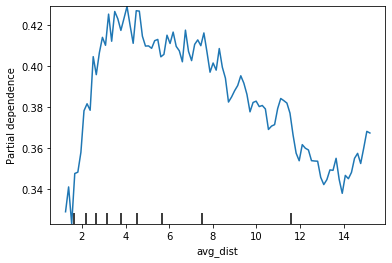

In [25]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(model,X_test,[6])

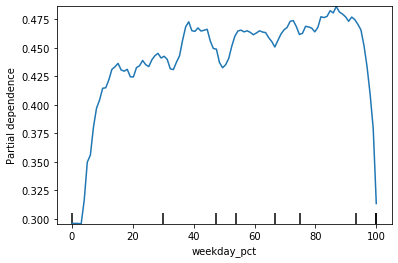

In [26]:
plot_partial_dependence(model,X_test,[5])

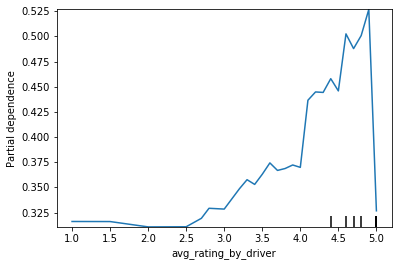

In [27]:
plot_partial_dependence(model,X_test,[7])

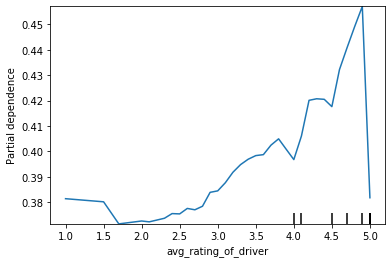

In [28]:
plot_partial_dependence(model,X_test,[1])

Looking at partial dependence plots (PDP) of the model. The strongest partial dependence is on average distance. The highest partial dependence occurs for relatively short trips, declining for longer ones. That's also where the features tend to be, so there may just be more training examples in this one. 

But assuming it's a real relationship, we might want to imagine a scenario or hypothetical cause to exlain it. Speculating, maybe riders who use very short trips are wealthier than people who reserve their usage for longer trips. In this case, wealth is a hidden variable that causes different usage scenarios but shows up as average distance. 

In conclusion, looks like there's some interesting data to look at in your company! I hope that you'll take interest in my work too.